In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.stats import fisher_exact
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
import bff
import pingouin as pg
import researchpy
from sklearn.preprocessing import StandardScaler

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
from adjustText import adjust_text # For nonoverlapping text labels on plots
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
# Load file (from same directory as the notebook)
df = pd.read_csv(("Study2.csv"))
df

,ID,age,ZIP,education,gender,Condition,cond,ide,ide_inverse,ide_ms,...,change2,change3,change4,change5,change6,change7,change8,change9,Affect,emotion
0,201,32.0,90046,Graduate degree,0,Low,1,78,22,aLiberal,...,3,-6,7,0,1,0,7,3,12.77,8.51
1,202,50.0,46808,Some college,1,Low,1,46,54,Conservative,...,-38,-30,0,-60,10,39,38,11,16.67,16.67
2,203,23.0,33068,High school diploma,0,Low,1,5,95,Conservative,...,52,-13,-7,-14,4,-17,3,-8,0.00,0.00
3,204,66.0,38824,High school diploma,1,Low,1,30,70,Conservative,...,9,23,-76,-69,-9,-29,-5,8,1.35,0.00
4,205,35.0,90012,Some college,0,Low,1,91,9,aLiberal,...,1,1,2,10,13,13,8,2,33.33,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,896,61.0,42220,Some college,1,High,2,48,52,Conservative,...,5,-9,-1,9,7,4,-4,14,0.00,0.00
696,897,71.0,54481,Graduate degree,0,High,2,100,0,aLiberal,...,0,0,0,2,0,0,-3,10,3.49,1.16
697,898,70.0,27371,High school diploma,1,High,2,21,79,Conservative,...,10,-1,-5,-5,-31,-5,4,-2,38.10,4.76
698,899,48.0,13501,Some college,0,High,2,50,50,Conservative,...,21,-49,22,17,11,30,15,-24,0.00,0.00


In [3]:
df_policy = pd.wide_to_long(df, stubnames=['change'], i=['ID', 'Condition','ide', 'ide_ms', 'ide_inverse'] , j='policy').reset_index()
df_policy

,ID,Condition,ide,ide_ms,ide_inverse,policy,cond,emotion,gender,ZIP,education,Affect,age,change
0,201,Low,78,aLiberal,22,1,1,8.51,0,90046,Graduate degree,12.77,32.0,2
1,201,Low,78,aLiberal,22,2,1,8.51,0,90046,Graduate degree,12.77,32.0,3
2,201,Low,78,aLiberal,22,3,1,8.51,0,90046,Graduate degree,12.77,32.0,-6
3,201,Low,78,aLiberal,22,4,1,8.51,0,90046,Graduate degree,12.77,32.0,7
4,201,Low,78,aLiberal,22,5,1,8.51,0,90046,Graduate degree,12.77,32.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,900,Low,0,Conservative,100,5,1,0.00,0,33870,College degree,0.00,22.0,0
6296,900,Low,0,Conservative,100,6,1,0.00,0,33870,College degree,0.00,22.0,0
6297,900,Low,0,Conservative,100,7,1,0.00,0,33870,College degree,0.00,22.0,0
6298,900,Low,0,Conservative,100,8,1,0.00,0,33870,College degree,0.00,22.0,-47


In [4]:
# Group and average data within participant and PE bin
AVDATA = df_policy.groupby(["ID", 'Condition', 'ide_ms'], as_index=False).mean()
AVDATA

,ID,Condition,ide_ms,ide,ide_inverse,policy,cond,emotion,Affect,age,change
0,201,Low,aLiberal,78.0,22.0,5.0,1.0,8.51,12.77,32.0,1.888889
1,202,Low,Conservative,46.0,54.0,5.0,1.0,16.67,16.67,50.0,-5.111111
2,203,Low,Conservative,5.0,95.0,5.0,1.0,0.00,0.00,23.0,-1.888889
3,204,Low,Conservative,30.0,70.0,5.0,1.0,0.00,1.35,66.0,-15.777778
4,205,Low,aLiberal,91.0,9.0,5.0,1.0,0.00,33.33,35.0,7.222222
...,...,...,...,...,...,...,...,...,...,...,...
695,896,High,Conservative,48.0,52.0,5.0,2.0,0.00,0.00,61.0,4.111111
696,897,High,aLiberal,100.0,0.0,5.0,2.0,1.16,3.49,71.0,2.333333
697,898,High,Conservative,21.0,79.0,5.0,2.0,4.76,38.10,70.0,-4.000000
698,899,High,Conservative,50.0,50.0,5.0,2.0,0.00,0.00,48.0,7.333333


In [5]:
AVDATA_Libs = AVDATA.loc[AVDATA['ide_ms']=='Liberal']
AVDATA_Cons = AVDATA.loc[AVDATA['ide_ms']=='Conservative']
AVDATA_low = AVDATA.loc[AVDATA['Condition']=='Low']
AVDATA_high = AVDATA.loc[AVDATA['Condition']=='High']

<IPython.core.display.Javascript object>


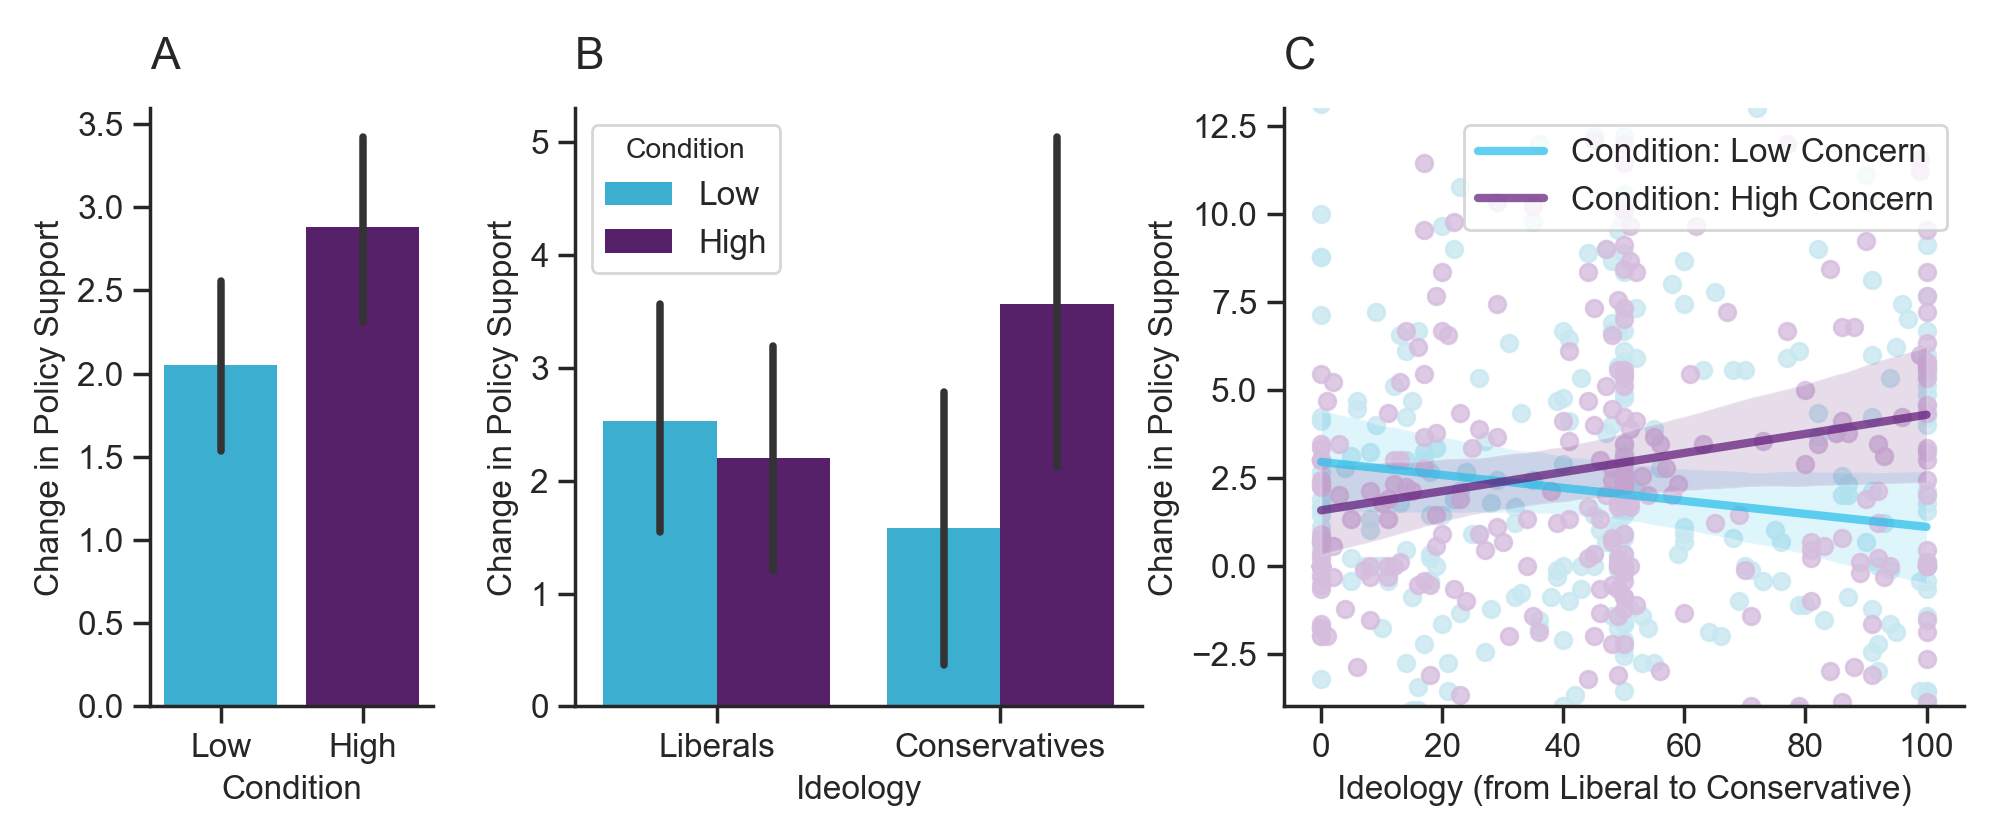

In [7]:
colors = ["#23BCE9", "#5D1576"]

fig, ax = plt.subplots(1,3, figsize=(10,4.2), gridspec_kw={"width_ratios": [0.5,1,1.2]})

sns.barplot(x="Condition", y="change", data=df_policy, \
            palette=colors, edgecolor="", errcolor=".2", \
            ax=ax[0]) 
ax[0].set_ylabel("Change in Policy Support")
sns.barplot(x="ide_ms", y="change", hue='Condition', data=AVDATA, \
            palette=colors, edgecolor="", errcolor=".2", \
            ax=ax[1]) 
sns.regplot(x=AVDATA_low.ide_inverse, y=AVDATA_low.change, scatter_kws={"color": "#C8E8F1"}, \
            line_kws={"color":"#23BCE9","alpha":0.7,"lw":3}, ax=ax[2])
sns.regplot(x=AVDATA_high.ide_inverse, y=AVDATA_high.change, scatter_kws={"color": "#D6BDDE"}, \
            line_kws={"color":"#5D1576","alpha":0.7,"lw":3}, ax=ax[2])
ax[2].set_ylabel("Change in Policy Support")
ax[2].set_xlabel("Ideology (from Liberal to Conservative)")
ax[2].legend(['Condition: Low Concern', 'Condition: High Concern'], loc="upper right")
ax[1].set_xticklabels(["Liberals", "Conservatives"])
ax[1].set_xlabel("Ideology")
ax[1].set_ylabel("Change in Policy Support")
plt.ylim(-4,13)
bff.panellabel(ax[0], "A")
bff.panellabel(ax[1], "B")
bff.panellabel(ax[2], "C")
sns.despine()
plt.tight_layout()
plt.savefig('Fig6.png', dpi=300, format="png")

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Load R in Python
%load_ext rpy2.ipython

In [12]:
# Load the R library lmerTest
%R library(lmerTest)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [13]:
# Send R the dataset
%Rpush df_policy

In [14]:
%%R

M <- lmer(change ~ Condition + (1 | policy), data = df_policy)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: change ~ Condition + (1 | policy)
   Data: df_policy

REML criterion at convergence: 52147

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.8368 -0.2961 -0.1248  0.2873  6.4479 

Random effects:
 Groups   Name        Variance Std.Dev.
 policy   (Intercept)   1.264   1.124  
 Residual             229.864  15.161  
Number of obs: 6300, groups:  policy, 9

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)     2.8826     0.4613   11.5718   6.249 5.01e-05 ***
ConditionLow   -0.8333     0.3820 6290.0000  -2.181   0.0292 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
ConditionLw -0.411


In [15]:
%%R

M <- lmer(change ~ Condition*ide_inverse + (1 | policy), data = df_policy)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: change ~ Condition * ide_inverse + (1 | policy)
   Data: df_policy

REML criterion at convergence: 52146.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.7831 -0.3009 -0.1110  0.2832  6.4284 

Random effects:
 Groups   Name        Variance Std.Dev.
 policy   (Intercept)   1.265   1.125  
 Residual             229.357  15.145  
Number of obs: 6300, groups:  policy, 9

Fixed effects:
                           Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)               1.573e+00  6.054e-01  3.428e+01   2.599 0.013706 *  
ConditionLow              1.374e+00  6.846e-01  6.288e+03   2.007 0.044794 *  
ide_inverse               2.717e-02  8.137e-03  6.288e+03   3.339 0.000845 ***
ConditionLow:ide_inverse -4.562e-02  1.174e-02  6.288e+03  -3.888 0.000102 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          

In [50]:
%%R

M <- lmer(change ~ Condition*ide_ms + (1 | policy), data = df_policy)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: change ~ Condition * ide_ms + (1 | policy)
   Data: df_policy

REML criterion at convergence: 52136.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.8100 -0.3138 -0.1128  0.2816  6.4066 

Random effects:
 Groups   Name        Variance Std.Dev.
 policy   (Intercept)   1.264   1.124  
 Residual             229.589  15.152  
Number of obs: 6300, groups:  policy, 9

Fixed effects:
                                 Estimate Std. Error        df t value Pr(>|t|)
(Intercept)                        2.2021     0.5335   20.6921   4.128 0.000491
ConditionLow                       0.3307     0.5416 6288.0000   0.611 0.541495
ide_msConservative                 1.3648     0.5376 6288.0000   2.538 0.011159
ConditionLow:ide_msConservative   -2.3181     0.7637 6288.0000  -3.035 0.002412
                                   
(Intercept)                     ***
ConditionLow                       
